In [1]:
import os
import pyvips
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import time
import cProfile

os.environ['VIPS_DISC_THRESHOLD'] = '10gb'

# Params
seed = 42
max_tile_num = 64
size = 2048
scale = 0.25
max_outl_ratio = 0.80

# Paths
root = '/media/latlab/MR/projects/kaggle-ubc-ocean'
data_dir = os.path.join(root, 'data')
results_dir = os.path.join(root, 'results')
train_csv = 'train.csv'
train_image_dir = os.path.join(data_dir, 'train_images')
train_thumbnail_dir = os.path.join(data_dir, 'train_thumbnails')
out_dir = os.path.join(results_dir, f'train_tiles_random_{size}_p{int(scale*100)}_outl{int(max_outl_ratio*100)}')

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

def random_idx(img_h, img_w, size):
    y = random.randrange(0, img_h-size)
    x = random.randrange(0, img_w-size)
    return (y, y + size, x, x + size)

def extract_image_tiles(p_img, folder, size: int, scale: float, drop_thr: float, max_tile_num: int) -> list:
    im = pyvips.Image.new_from_file(p_img)
    
    if im.height < 5000 and im.width < 5000: # TODO exact detection of TMA
        # TMA tiles
        w = h = size = size*2
        scale = scale/2
    else:
        # WSI tiles
        w = h = size

    # Check if image is smaller than tile size
    if size > im.width and size > im.height:
        tile = im.numpy()[..., :3]
        out_img = Image.fromarray(tile)

        # Save
        p_img = os.path.join(folder, f"{0:06}_0-0.png")
        out_img.save(p_img)

        return [p_img], [(0, im.height, 0, im.width)], int(im.height), int(im.width)
    
    # Random idxs
    idxs = [random_idx(im.height, im.width, size) for _ in range(200)]

    # Tiling
    files = []
    valid_idx_list = []
    for k, (y, y_, x, x_) in enumerate(idxs):
        tile = im.crop(x, y, min(w, im.width - x), min(h, im.height - y)).numpy()[..., :3]
        
        # Check tile size and drop/pad if necessary
        if tile.shape[:2] != (h, w):
            if any((1-np.array(tile.shape[:2])/size) >= drop_thr):
                continue
            tile_ = tile
            tile_size = (h, w) if tile.ndim == 2 else (h, w, tile.shape[2])
            tile = np.zeros(tile_size, dtype=tile.dtype)
            tile[:tile_.shape[0], :tile_.shape[1], ...] = tile_

        # Make background white
        black_bg = np.sum(tile, axis=2) == 0
        tile[black_bg, :] = 255
        
        # Check if tile is mostly white background
        mask_white_bg = np.mean(tile, axis=2) > (0.85*255)
        if np.sum(mask_white_bg) > (np.prod(mask_white_bg.shape) * max_outl_ratio):
            continue
    
        # Resize
        new_size = int(size * scale), int(size * scale)
        out_img = Image.fromarray(tile).resize(new_size, Image.LANCZOS)
        
        # Save
        p_img = os.path.join(folder, f"{k:06}_{int(x)}-{int(y)}.png")
        out_img.save(p_img)
        files.append(p_img)

        valid_idx_list += [(y, y_, x, x_)]
        if len(files) >= max_tile_num:
            break
    return files, valid_idx_list, int(im.height), int(im.width)

def extract_prune_tiles(idx_path_img, folder, size: int, scale: float, drop_thr: float, max_tile_num: int) -> None:
    idx, p_img = idx_path_img
    print(f"processing #{idx}: {p_img}")
    name, _ = os.path.splitext(os.path.basename(p_img))
    folder = os.path.join(folder, name)
    os.makedirs(folder, exist_ok=True)
    tiles, _, _, _ = extract_image_tiles(p_img, folder, size, scale, drop_thr, max_tile_num)

## Show the image tiles with segmentations for one test image

64
image size: (512, 512, 3)


(0.0, 20008.0)

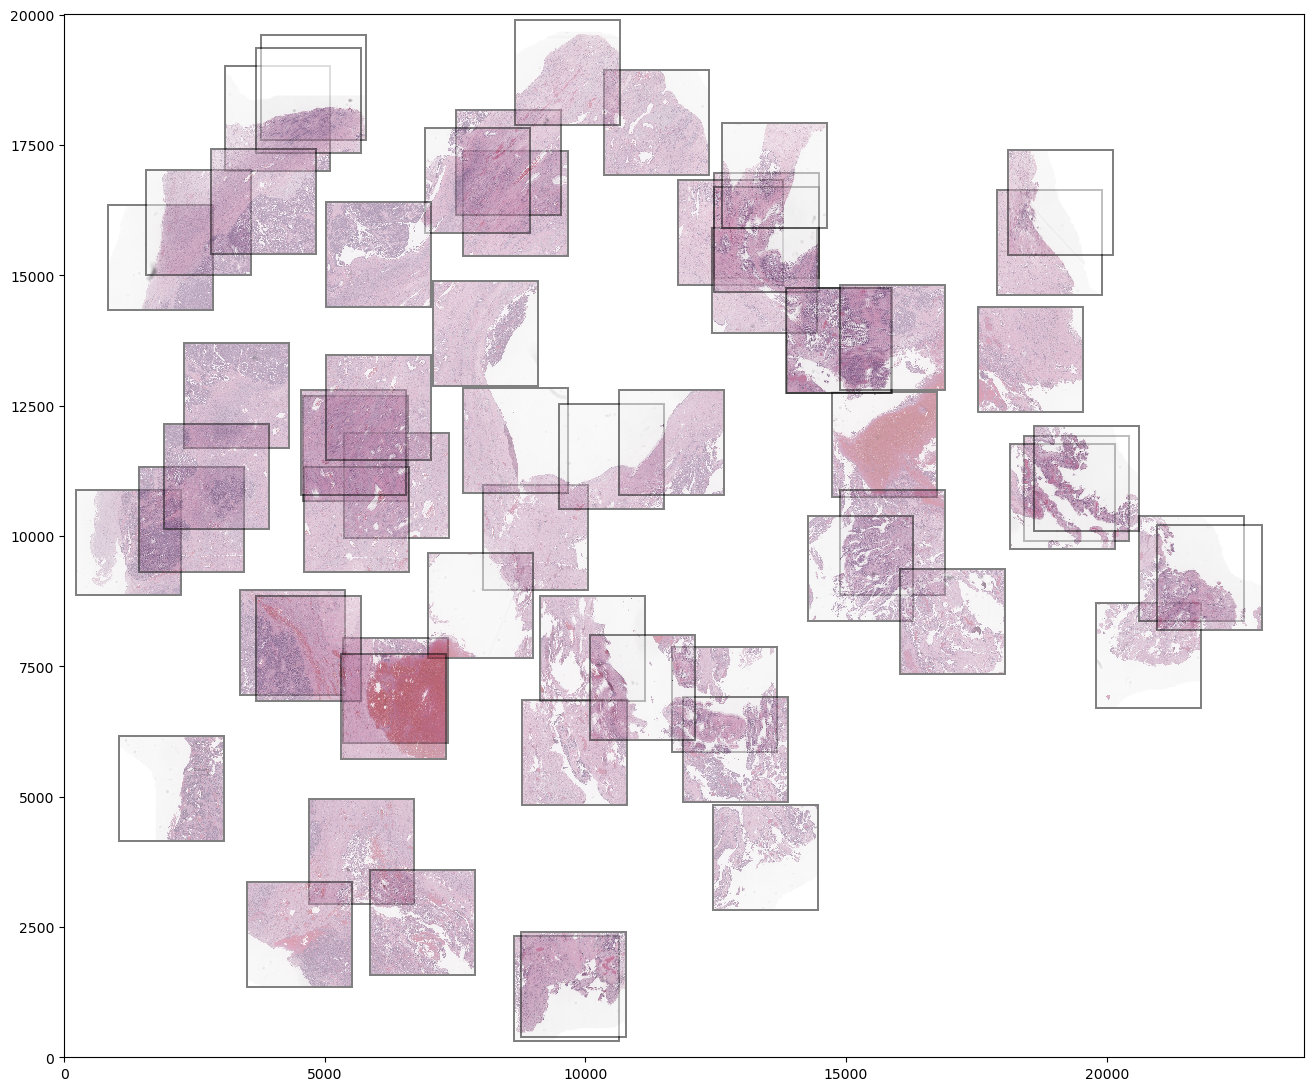

In [2]:
test_img_id = '4'
# test_img_id = '13987'
# test_img_id = '91'
# test_img_id = '281'
# test_img_id = '48734'

def frame_image(img, frame_width):
    b = frame_width # border size in pixel
    ny, nx = img.shape[0], img.shape[1] # resolution / number of pixels in x and y
    if img.ndim == 3: # rgb or rgba array
        framed_img = np.zeros((b+ny+b, b+nx+b, img.shape[2]))
    elif img.ndim == 2: # grayscale image
        framed_img = np.zeros((b+ny+b, b+nx+b))
    framed_img[b:-b, b:-b] = img
    return framed_img

os.makedirs('/tmp/ubc', exist_ok=True)
tiles_img, _, img_height, img_width = extract_image_tiles(os.path.join(train_image_dir, f'{test_img_id}.png'), '/tmp/ubc', 
                                                          size=size, scale=scale, drop_thr=max_outl_ratio, max_tile_num=max_tile_num)
print(len(tiles_img))

names = [os.path.splitext(os.path.basename(p_img))[0] for p_img in tiles_img]
pos = [name.split("_")[-1] for name in names]
idx_x, idx_y = zip(*[list(map(int, p.split("-"))) for p in pos])

fig = plt.figure(figsize=(16, 20))
ax = plt.gca()
for p_img, x, y in zip(tiles_img, idx_x, idx_y):
    img = plt.imread(p_img)
    ax.imshow(frame_image(img, 10), extent=(x, x+size, img_height-y-size, img_height-y), alpha=0.5, interpolation='none')
print(f"image size: {img.shape}")
plt.xlim(0, img_width)
plt.ylim(0, img_height)

## Export all image tiles¶

In [3]:
import glob
from tqdm.auto import tqdm
from joblib import Parallel, delayed

os.makedirs(out_dir, exist_ok=True)

ls = sorted(glob.glob(os.path.join(train_image_dir, '*.png')))
print(f"found images: {len(ls)}")
img_name = lambda p_img: os.path.splitext(os.path.basename(p_img))[0]
    
_= Parallel(n_jobs=8)(
    delayed(extract_prune_tiles)
    (id_pimg, out_dir, size=size, drop_thr=max_outl_ratio, scale=scale, max_tile_num=max_tile_num)
    for id_pimg in tqdm(enumerate(ls), total=len(ls))
)

found images: 538


  0%|          | 0/538 [00:00<?, ?it/s]

processing #0: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/10077.png
processing #1: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/10143.png
processing #2: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/1020.png
processing #3: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/10246.png
processing #4: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/10252.png
processing #5: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/10469.png
processing #6: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/10548.png
processing #7: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/10642.png
processing #8: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/1080.png
processing #9: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/10800.png
processing #10: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/10896.png
processing #11: /media/latlab/MR/projects/kaggle-ubc-oc

/home/latlab/anaconda3/envs/ubc-ocean/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


processing #19: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/12244.png
processing #20: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/12442.png
processing #21: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/1252.png
processing #22: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/12522.png
processing #23: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/1289.png
processing #24: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/12902.png
processing #25: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/1295.png
processing #26: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/13364.png
processing #27: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/13387.png
processing #28: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/13526.png
processing #29: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/13568.png
processing #30: /media/latlab/MR/projects/kagg

## Show some samples

found folders: 538
found images: 32550


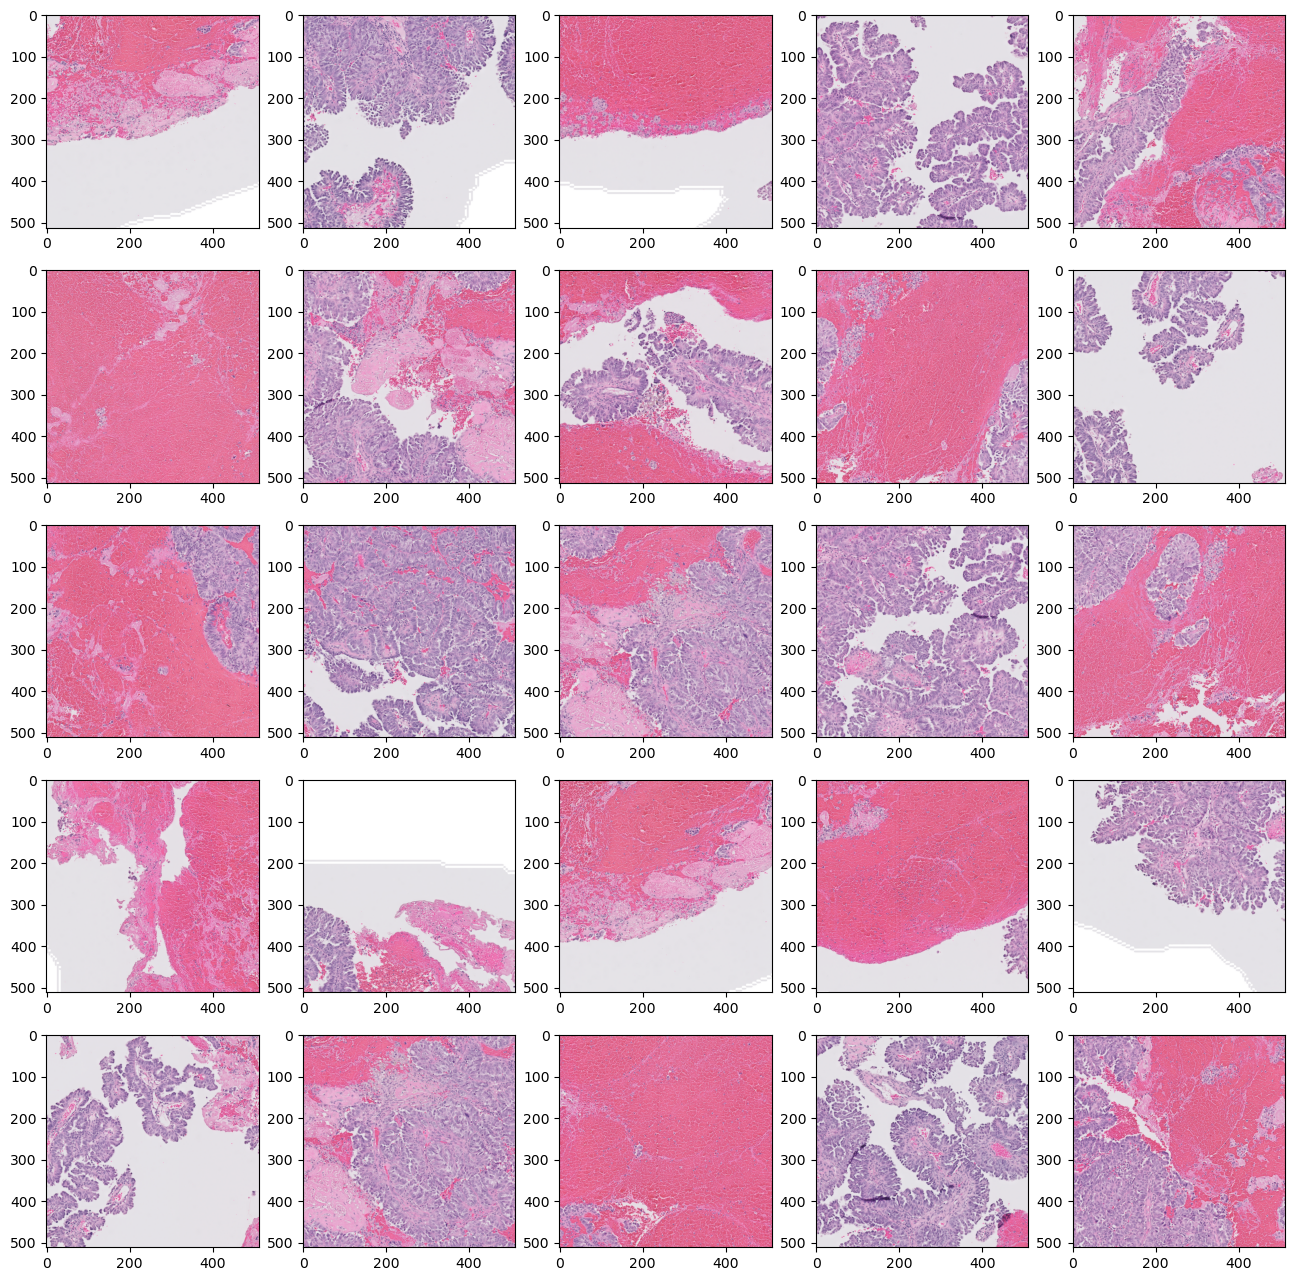

In [4]:
ls = [p for p in glob.glob(out_dir + '/*') if os.path.isdir(p)]
print(f"found folders: {len(ls)}")
ls = glob.glob(out_dir + '/*/*.png')
print(f"found images: {len(ls)}")

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(16, 16))
for i, p_img in enumerate(ls[:25]):
    img = plt.imread(p_img)
    ax = axes[i // 5, i % 5]
    ax.imshow(img)